In [3]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  
import pandas as pd
import scipy.sparse as sps

from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [16]:
def load_URM(file_path):

    data = pd.read_csv(file_path)


    user_list = data['row'].tolist()
    item_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (user_list, item_list))).tocsr()

In [4]:
def load_ICM(file_path):

    data = pd.read_csv(file_path)

    item_list = data['row'].tolist()
    attribute_list = data['col'].tolist()
    rating_list = data['data'].tolist()

    return sps.coo_matrix((rating_list, (item_list, attribute_list))).tocsr()

In [18]:
URM_all = load_URM('input/data_train.csv')
ICM_all = load_ICM('input/data_ICM_genre.csv')
#print(ICM_all)

In [9]:
ICM_all.shape

(18059, 8)

In [10]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [11]:
print(features_per_item.shape)
print(items_per_feature.shape)

(18059,)
(8,)


In [12]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

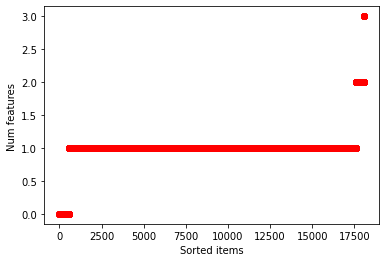

In [13]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

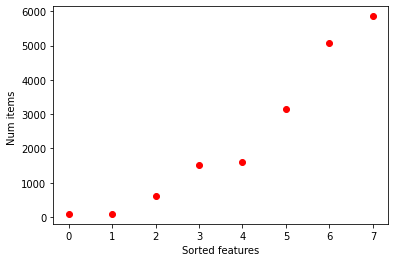

In [14]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

In [20]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions


In [21]:
#import traceback

#try:
#    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
#except Exception as e:
#    traceback.print_exc()

In [23]:
#block_size = 100

#numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
#numerator_block.shape

(100, 18059)

In [24]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 18059 (100.0%), 6644.49 column/sec. Elapsed time 2.72 sec


<18059x18059 sparse matrix of type '<class 'numpy.float32'>'
	with 1749930 stored elements in Compressed Sparse Row format>

In [27]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores


In [28]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 18059 (100.0%), 7213.71 column/sec. Elapsed time 2.50 sec


In [29]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[2008 4887 8841 2987 5015]
[1070 5885  654  652  640]
[14397  3459  3291  5819  5786]
[ 329 1103  150  151  538]
[17106 17584  4094 17733 17734]
[13484 12067  9690  2514 15318]
[ 2987  1185  6940  7083 10432]
[1140 1040  720 1176  512]
[ 5620  3200 12556  6530  5675]
[4304 5099 5105 5110 5130]


# Hyperparameters tuning

## Number of neighbors

In [30]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6897.06 column/sec. Elapsed time 2.62 sec
EvaluatorHoldout: Processed 13643 (100.0%) in 3.97 sec. Users per second: 3437
ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6682.30 column/sec. Elapsed time 2.70 sec
EvaluatorHoldout: Processed 13643 (100.0%) in 4.87 sec. Users per second: 2802
ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6479.89 column/sec. Elapsed time

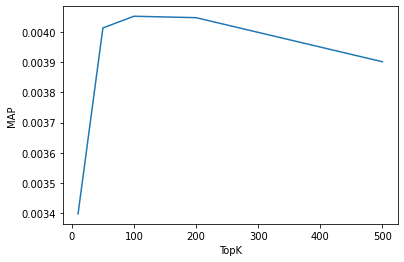

In [31]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### So we should take TopK = 100 (I guess)

## Shrinkage

In [47]:
x_tick = range(0,11)
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6399.85 column/sec. Elapsed time 2.82 sec
EvaluatorHoldout: Processed 13643 (100.0%) in 5.46 sec. Users per second: 2500
ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6508.85 column/sec. Elapsed time 2.77 sec
EvaluatorHoldout: Processed 13643 (100.0%) in 5.70 sec. Users per second: 2393
ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6343.09 column/sec. Elapsed time

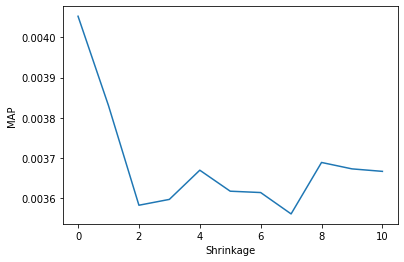

In [49]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### ...dafuq?

# Feature weighting

## IDF

In [34]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(18059, 8)
(8,)


In [35]:
np.sort(items_per_feature)

array([  91,  103,  624, 1520, 1596, 3142, 5062, 5853], dtype=int32)

In [36]:
np.sort(IDF)

array([1.12668983, 1.27188251, 1.74878464, 2.42614368, 2.47493384,
       3.36524909, 5.16667047, 5.29053995])

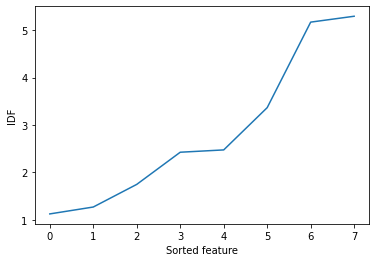

In [37]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

In [38]:
from scipy.sparse import diags
diags(IDF)

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements (1 diagonals) in DIAgonal format>

In [39]:
ICM_idf = ICM_all.copy()
ICM_idf = ICM_idf*diags(IDF)

In [40]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 2 ( 0.0%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 559 ( 3.1%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 7895.89 column/sec. Elapsed time 2.29 sec
EvaluatorHoldout: Processed 13643 (100.0%) in 4.40 sec. Users per second: 3103


PRECISION                      0.010445
PRECISION_RECALL_MIN_DEN       0.010479
RECALL                         0.001348
MAP                            0.002946
MAP_MIN_DEN                    0.002954
MRR                            0.026878
NDCG                           0.010022
F1                             0.002388
HIT_RATE                        0.09624
ARHR_ALL_HITS                  0.028108
NOVELTY                        0.008634
AVERAGE_POPULARITY             0.042886
DIVERSITY_MEAN_INTER_LIST      0.985204
DIVERSITY_HERFINDAHL           0.998513
COVERAGE_ITEM                  0.300017
COVERAGE_ITEM_CORRECT          0.033501
COVERAGE_USER                  0.999487
COVERAGE_USER_CORRECT           0.09619
DIVERSITY_GINI                 0.072988
SHANNON_ENTROPY               10.607408
RATIO_DIVERSITY_HERFINDAHL     0.998898
RATIO_DIVERSITY_GINI           0.294471
RATIO_SHANNON_ENTROPY          0.856117
RATIO_AVERAGE_POPULARITY       0.210652
RATIO_NOVELTY                  0.050776


#### Alternative feature weighting: BM25

# ...

In [ ]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=100)

In [53]:
import pandas as pd
from tqdm import tqdm
submission = pd.DataFrame(columns=['user_id', 'item_list'])

for i in tqdm(range(13650), desc="getting recommendations"):
    item_list = recommender.recommend(i, 10)
    submission.loc[i] = [i, ' '.join([str(i) for i in item_list])]

submission

getting recommendations: 100%|██████████| 13650/13650 [00:19<00:00, 716.04it/s]


,user_id,item_list
0,0,7001 6354 10943 2008 11057 16342 8417 11948 12...
1,1,5027 1270 739 291 5902 5043 1283 5030 5051 757
2,2,5572 14963 5483 819 5434 3176 15119 12556 5849...
3,3,5432 4545 4571 895 5410 5414 5420 5422 5424 4556
4,4,13237 4265 1547 1554 10975 1605 11003 10978 16...
...,...,...
13645,13645,1229 1236 1205 14109 14102 1946 14473 14491 12...
13646,13646,16114 12765 6210 84 3890 16395 16469 16331 163...
13647,13647,6989 5090 8054 12227 5047 5050 7012 5052 5069 ...
13648,13648,2987 4887 1185 15342 15347 15371 15324 15373 6...


In [54]:
from datetime import datetime
submission.to_csv(f'output/cbf_genre_{str(datetime.now())}.csv', index=False)